In [1]:
%%capture
import sys
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap

DATA_PATH = 'data/'

In [2]:
# Data originally from: https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction
train = pd.read_csv(DATA_PATH+'train.csv')
test = pd.read_csv(DATA_PATH+'test.csv')

# Split train into train & val
# train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
#                               stratify=train['satisfaction'], random_state=42)
# train.shape, val.shape, test.shape

In [3]:
def wrangle(X):
    X = X.copy()

    # These columns are either useless data or variables we shouldn't use.
#     unwanted_columns = ['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age',
#                         'Type of Travel', 'Class', 'Flight Distance']
    
    # Nevermind, let's use 'em anyway.
    unwanted_columns = ['Unnamed: 0', 'id']

    for column in unwanted_columns:
        X = X.drop(column, axis=1)
    
    # Replace NA values in this column with zero. 
    X['Arrival Delay in Minutes'] = X['Arrival Delay in Minutes'].fillna(0)
    
    X['Class'] = X['Class'].replace({"Eco Plus": "Eco"})

    return X

train = wrangle(train)
# val = wrangle(val)
test = wrangle(test)

# Get mean baseline score:
majority_class = train['satisfaction'].mode()[0]
y_pred = [majority_class] * len(train['satisfaction'])

accuracy_score(train['satisfaction'], y_pred)

0.5666673082845703

In [4]:
target = 'satisfaction'
features = train.drop(columns=[target]).columns

encoder = ce.OrdinalEncoder()

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_train_encoded = encoder.fit_transform(X_train)
X_test_transformed = encoder.transform(X_test)

model = RandomForestClassifier(random_state=0, n_jobs=-2, n_estimators=500)
model.fit(X_train_encoded, y_train)
print(model.score(X_test_transformed, y_test))

0.9631582999692023


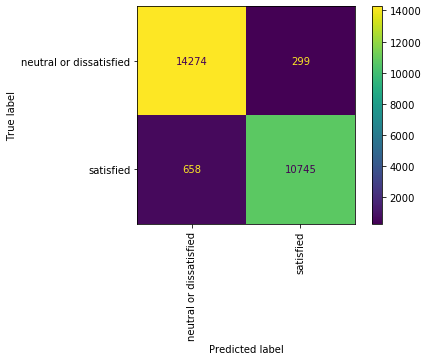

In [5]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test_transformed, y_test, values_format='.0f', xticks_rotation='vertical');

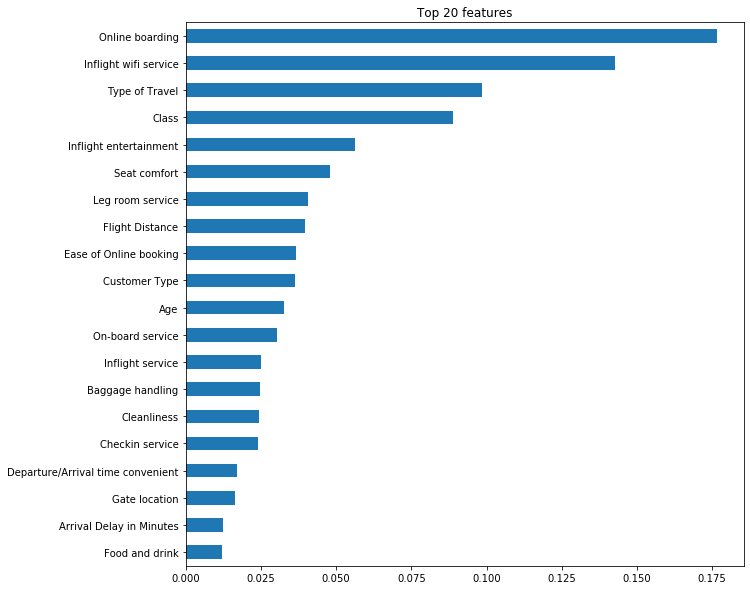

In [6]:
%matplotlib inline

# Get feature importances
importances = pd.Series(model.feature_importances_, X_train_encoded.columns)

# Plot top n feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [7]:
permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
);

permuter.fit(X_test_transformed, y_test)

eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=test[features].columns.tolist() # must be a list
)

Weight,Feature
0.1315 ± 0.0014,Inflight wifi service
0.1292 ± 0.0027,Type of Travel
0.0523 ± 0.0022,Customer Type
0.0354 ± 0.0021,Online boarding
0.0248 ± 0.0011,Checkin service
0.0198 ± 0.0010,Baggage handling
0.0180 ± 0.0012,Class
0.0173 ± 0.0012,Seat comfort
0.0165 ± 0.0006,Inflight service
0.0154 ± 0.0010,Cleanliness


In [8]:
for item in encoder.mapping:
    print(item['col'])
    print("- - - - -")
    print(item['mapping'])
    print("\n")

Gender
- - - - -
Male      1
Female    2
NaN      -2
dtype: int64


Customer Type
- - - - -
Loyal Customer       1
disloyal Customer    2
NaN                 -2
dtype: int64


Type of Travel
- - - - -
Personal Travel    1
Business travel    2
NaN               -2
dtype: int64


Class
- - - - -
Eco         1
Business    2
NaN        -2
dtype: int64




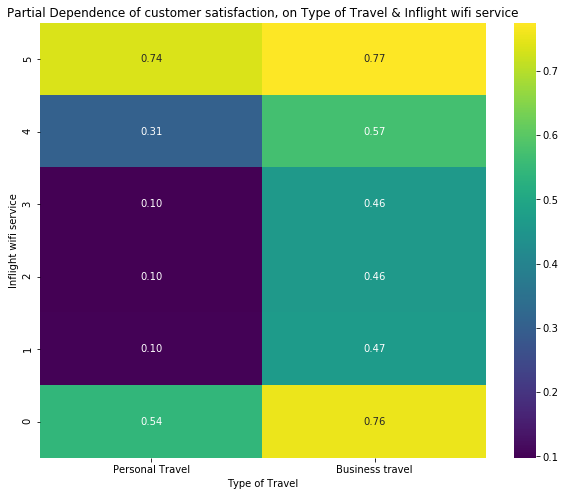

In [9]:
def build_pdp_from_features(feature_1, feature_2, feature_1_map=None, feature_2_map=None):
    selected_features = [feature_1, feature_2]
    
    interaction = pdp_interact(
        model=model,
        dataset=X_test_transformed,
        model_features=X_test_transformed.columns,
        features=selected_features,
        cust_grid_points= [[1,2],[0,1,2,3,4,5]]
    )
    
    pdp = interaction.pdp.pivot_table(
        values='preds', 
        columns=selected_features[0], # First feature on x axis
        index=selected_features[1]    # Next feature on y axis
    )[::-1]  # Reverse the index order so y axis is ascending
    
    if feature_1_map and feature_2_map:
        pdp = pdp.rename(
            columns=dict(zip(range(1,len(feature_1_map)), feature_1_map)),
            index=dict(zip(range(1,len(feature_2_map)), feature_2_map))
        )
        
    elif feature_1_map:
        pdp = pdp.rename(
            columns=dict(zip(range(1,len(feature_1_map)+1), feature_1_map))
        )
    elif feature_2_map:
        pdp = pdp.rename(
            index=dict(zip(range(1,len(feature_2_map)+1), feature_2_map))
        )
        
    plt.figure(figsize=(10,8))
    sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
    plt.title('Partial Dependence of customer satisfaction, on ' +
              feature_1 + 
              ' & ' + 
              feature_2);
              
build_pdp_from_features('Type of Travel', 'Inflight wifi service', ['Personal Travel', 'Business travel'])

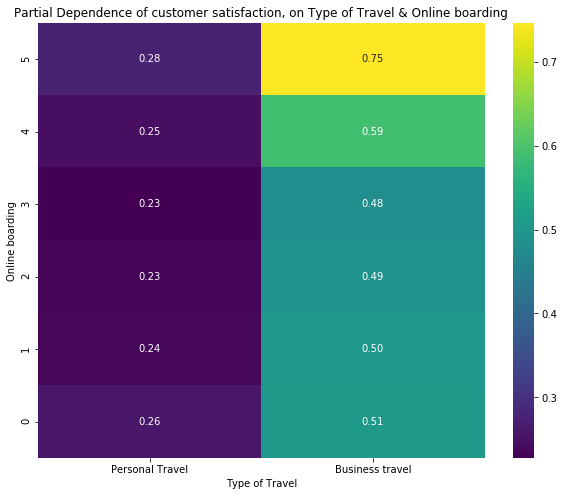

In [10]:
build_pdp_from_features('Type of Travel', 'Online boarding', ['Personal Travel', 'Business travel'])

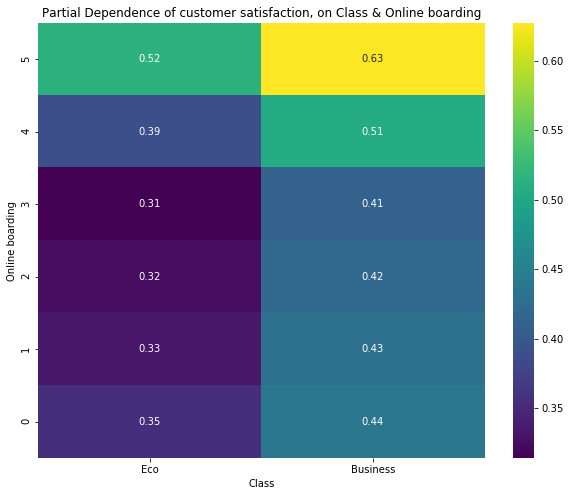

In [11]:
build_pdp_from_features('Class', 'Online boarding', ['Eco', 'Business'])

In [12]:
pd.crosstab(train['Class'], train['Type of Travel'])

Type of Travel,Business travel,Personal Travel
Class,,
Business,47508,2157
Eco,24147,30092


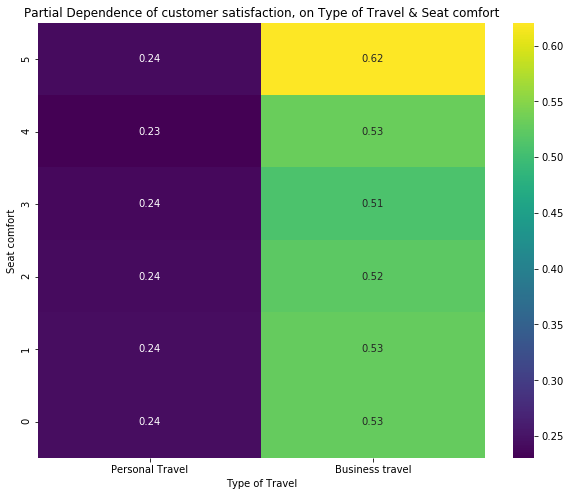

In [13]:
build_pdp_from_features('Type of Travel', 'Seat comfort', ['Personal Travel', 'Business travel'])

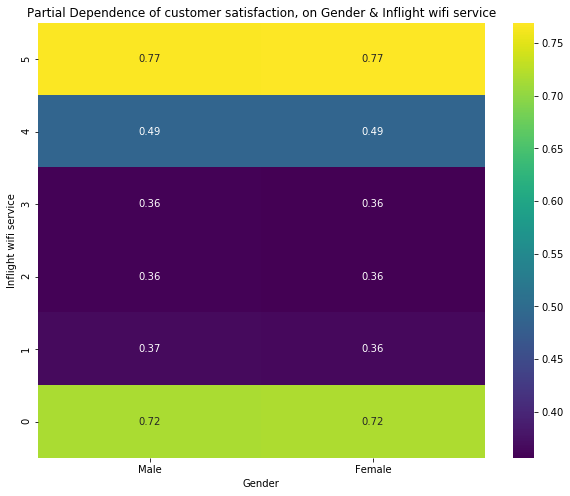

In [14]:
build_pdp_from_features('Gender', 'Inflight wifi service', ['Male', 'Female'])

In [15]:
test.iloc[[50]]

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
50,Female,Loyal Customer,58,Personal Travel,Eco,990,3,5,2,3,...,1,1,2,1,5,1,3,0,0.0,neutral or dissatisfied


In [16]:
row = X_test.iloc[[51]]

explainer = shap.TreeExplainer(model)
row_processed = encoder.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

In [17]:
# Wake me up when it's done... zzz...
from IPython.display import Audio
Audio("https://vignette.wikia.nocookie.net/finalfantasy/images/d/db/FFXV_Victory_Fanfare.ogg", autoplay=True)